In [1]:
# Author: Mikita Sazanovich

In [2]:
import os
import random
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

from kaldi.feat.mfcc import Mfcc, MfccOptions
from kaldi.matrix import SubVector, SubMatrix
from kaldi.util.options import ParseOptions
from kaldi.util.table import SequentialWaveReader, SequentialMatrixReader, MatrixWriter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

from tqdm import tqdm

In [3]:
NUM_PEOPLE = 0

np.random.seed(7)

train_wav_paths = []
train_classes = []
test_wav_paths = []
test_classes = []
wav_dir = os.path.join('VCTK-Corpus', 'wav48')
for num, person in enumerate(os.listdir(wav_dir)):
    NUM_PEOPLE += 1
    person_dir = os.path.join(wav_dir, person)
    wav_names = list(map(lambda wav_name: os.path.join(person_dir, wav_name), os.listdir(person_dir)))
    train_person_speech, test_person_speech = train_test_split(wav_names, test_size=0.2)
    train_wav_paths.extend(train_person_speech)
    train_classes.extend([num] * len(train_person_speech))
    test_wav_paths.extend(test_person_speech)
    test_classes.extend([num] * len(test_person_speech))
print('Number of people={}'.format(NUM_PEOPLE))
print('train:', len(train_wav_paths), len(train_classes))
print('test:', len(test_wav_paths), len(test_classes))

Number of people=108
train: 35113 35113
test: 8837 8837


In [4]:
def write_descriptor(wav_paths, desc_path):
    with open(desc_path, 'w') as output:
        for wav_path in wav_paths:
            output.write('{} {}\n'.format(wav_path, wav_path))
            
train_desc_path = 'train_desc.scp'
test_desc_path = 'test_desc.scp'
write_descriptor(train_wav_paths, train_desc_path)
write_descriptor(test_wav_paths, test_desc_path)

In [5]:
def compute_kaldi_features(desc_path, output_path, samp_freq=8000):
    print('Started processing', desc_path)
    rspec, wspec = 'scp:{}'.format(desc_path), 'ark:{}'.format(output_path)
    
    mfcc_opts = MfccOptions()
    mfcc_opts.frame_opts.samp_freq = samp_freq

    mfcc = Mfcc(mfcc_opts)
    sf = mfcc_opts.frame_opts.samp_freq
    
    with SequentialWaveReader(rspec) as reader, MatrixWriter(wspec) as writer:      
        for key, wav in reader:
            assert(wav.samp_freq >= sf)
            assert(wav.samp_freq % sf == 0)

            s = wav.data()
            s = s[:,::int(wav.samp_freq / sf)]
            m = SubVector(mean(s, axis=0))

            f = mfcc.compute_features(m, sf, 1.0)
            f = SubMatrix(scale(f))
            writer[key] = f
    print('Success! Result is written to', output_path)
            
train_kaldi_path = 'train_kaldi.ark'
test_kaldi_path = 'test_kaldi.ark'
compute_kaldi_features(train_desc_path, train_kaldi_path)
compute_kaldi_features(test_desc_path, test_kaldi_path)

Started processing train_desc.scp
Success! Result is written to train_kaldi.ark
Started processing test_desc.scp
Success! Result is written to test_kaldi.ark


In [6]:
def read_features(kaldi_path):
    features = []
    rspec = 'ark:{}'.format(kaldi_path)
    with SequentialMatrixReader(rspec) as reader:
        for key, mat in reader:
            features.append(torch.tensor(mat, dtype=torch.float))
    return features

train_features = read_features(train_kaldi_path)
test_features = read_features(test_kaldi_path)

In [7]:
print('Train:', len(train_features), len(train_classes))
print('Test:', len(test_features), len(test_classes))

Train: 35113 35113
Test: 8837 8837


In [8]:
class SpeakerIdentityLSTM(nn.Module):
    
    def __init__(self, feature_dim, hidden_dim, num_classes):
        super(SpeakerIdentityLSTM, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(feature_dim, hidden_dim, num_layers=1)
        
        self.hidden2class = nn.Linear(hidden_dim, num_classes)
        self.hidden = None
        self.softmax = nn.LogSoftmax(dim=1)
        
    def __init_hidden(self, batch_size):
        # The axes semantics are (num_layers, batch_size, hidden_dim)
        return (torch.zeros(1, batch_size, self.hidden_dim).cuda(),
                torch.zeros(1, batch_size, self.hidden_dim).cuda())
    
    def __get_class_scores(self, batch, lengths):
        self.hidden = self.__init_hidden(batch.size(0))
        packed_input = pack_padded_sequence(batch, lengths, batch_first=True)
        outputs, (ht, ct) = self.lstm(packed_input, self.hidden)
        class_scores = self.hidden2class(ht[-1])
        
        return class_scores
    
    def forward(self, batch, lengths):
        class_scores = self.__get_class_scores(batch, lengths)
        output = self.softmax(class_scores)
        
        return output
    
    def predict_classes(self, batch, lengths):
        class_scores = self.__get_class_scores(batch, lengths)
        classes = class_scores.argmax(dim=1)
        
        return classes

In [11]:
if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print(torch.cuda.get_device_name(current_device))

GeForce GTX 1080 Ti


In [12]:
def pack_feature_class_lists(features, classes, ids):
    ids = sorted(ids, key=lambda ind: features[ind].size(0), reverse=True)
    lengths = list(map(lambda ind: features[ind].size(0), ids))
    seq = list(map(lambda ind: features[ind], ids))
    inputs = pad_sequence(seq, batch_first=True).cuda()
    targets = torch.tensor(list(map(lambda ind: classes[ind], ids)), dtype=torch.long)
    return inputs, lengths, targets

EPOCHS = 5000
BATCH_SIZE = 1024
HIDDEN_DIM = 64

torch.manual_seed(7)
np.random.seed(7)

model = SpeakerIdentityLSTM(train_features[0].shape[1], HIDDEN_DIM, NUM_PEOPLE).cuda()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

N_train = len(train_features)
N_test = len(test_features)
train_ids = list(range(N_train))
test_ids = list(range(N_test))

train_losses = []
test_accuracies = []

for epoch in tqdm(range(EPOCHS)):
    np.random.shuffle(train_ids)
    
    model.train()
    train_loss = 0
    for i in range(0, N_train, BATCH_SIZE):
        model.zero_grad()
        train_inputs, train_lens, train_targets = pack_feature_class_lists(
            train_features, train_classes, train_ids[i:i+BATCH_SIZE])
        class_log_probs = model(train_inputs, train_lens).cpu()
        loss = criterion(class_log_probs, train_targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss)

    model.eval()
    correct = 0
    for i in range(0, N_test, BATCH_SIZE):
        test_inputs, test_lens, test_targets = pack_feature_class_lists(
            test_features, test_classes,test_ids[i:i+BATCH_SIZE])
        test_predictions = model.predict_classes(test_inputs, test_lens).cpu()
        correct += (test_predictions == test_targets).sum().item()
    accuracy = 100 * correct / N_test
    test_accuracies.append(accuracy)

100%|██████████| 5000/5000 [3:38:49<00:00,  2.66s/it]  


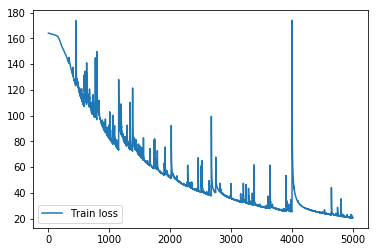

In [13]:
plt.plot(range(len(train_losses)), train_losses)
plt.legend(['Train loss'])
plt.show()

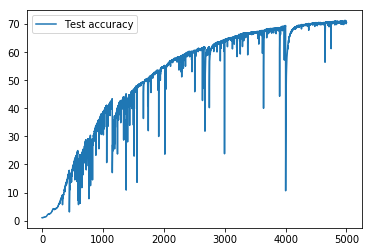

In [14]:
plt.plot(range(len(test_accuracies)), test_accuracies)
plt.legend(['Test accuracy'])
plt.show()